In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import cv2
import sys
import math
sys.setrecursionlimit(25000)
plt.rcParams['figure.figsize'] = [10, 10]

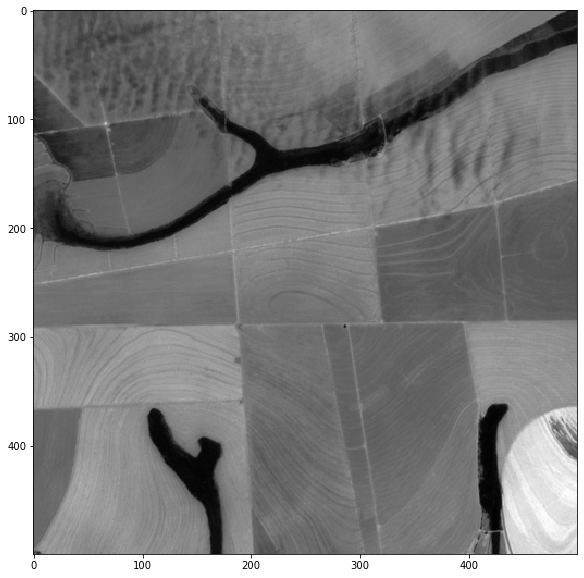

In [33]:
# raw image
img = cv2.imread("./data/talhao_101035/interest_b0420201015.tif", -1)
#img = cv2.imread("./data/talhao_100767/interest_b0420201015.tif", -1)
# image converted to 8bits
img_8bits = cv2.convertScaleAbs(img, alpha=0.03)


img_equalized = cv2.equalizeHist(img_8bits)
img_blur = cv2.GaussianBlur(img_8bits, (5,5), 0 )
img_lap = cv2.Laplacian(img_8bits, cv2.CV_64F)
img_lap = np.uint8(np.absolute(img_lap))

plt.imshow(img_8bits,cmap = 'gray')
plt.show()

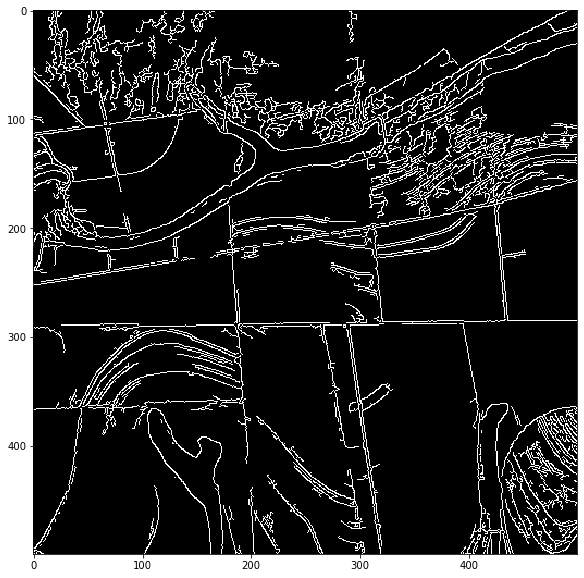

In [34]:
img_edges = cv2.Canny(img_8bits,10,50, None)
plt.imshow(img_edges,cmap = 'gray')
plt.show()

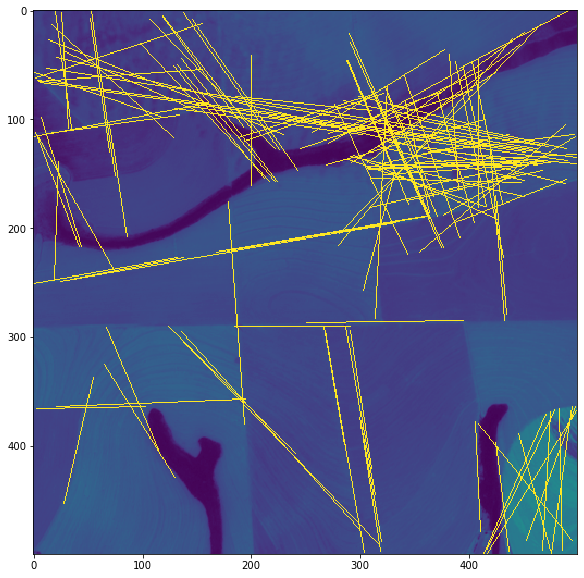

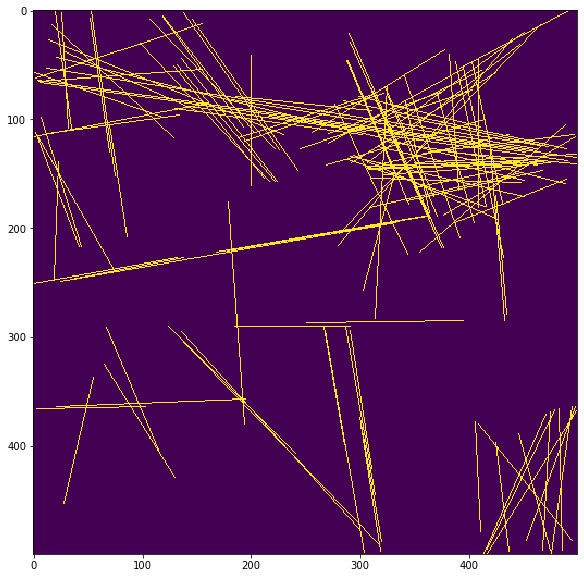

In [50]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 20

img_copy = np.copy(img_8bits)
img_blank = np.copy(img_8bits) * 0

# maximum gap in pixels between connectable line segments
lines_houghlinesp = cv2.HoughLinesP(img_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

for line in lines_houghlinesp:
    for x1,y1,x2,y2 in line:
        cv2.line(img_copy,(x1,y1),(x2,y2),(255,0,0),1)
        cv2.line(img_blank,(x1,y1),(x2,y2),(255,0,0),1)

# show image merged
plt.imshow(img_copy)
plt.show()

# show only lines
plt.imshow(img_blank)
plt.show()

64


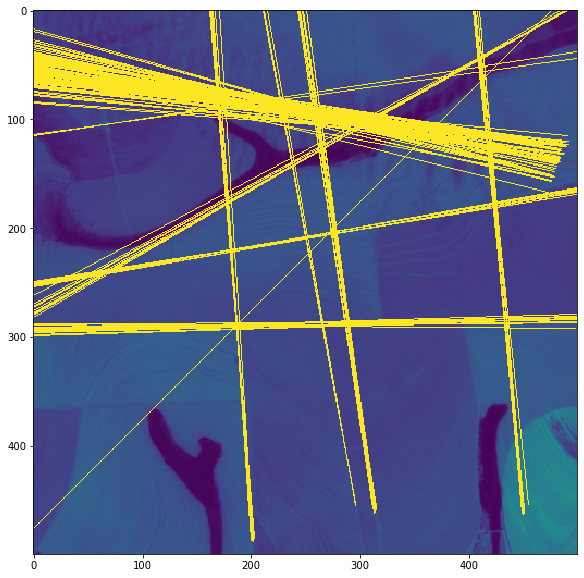

In [54]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 1000  # angular resolution in radians of the Hough grid
threshold = 132  # minimum number of votes (intersections in Hough grid cell)

img_copy = np.copy(img8)
img_blank = np.copy(img8) * 0

lines_houghlines = cv2.HoughLines(img_edges, rho, theta, threshold)

print( len(lines))

for line in lines_houghlines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 500*(-b))
    y1 = int(y0 + 500*(a))
    x2 = int(x0 - 500*(-b))
    y2 = int(y0 - 500*(a))
    cv2.line(img_copy, (x1, y1), (x2, y2), (255, 0, 0), 1)
    
    
# Draw the lines on the  image
plt.imshow(img_copy)
plt.show()

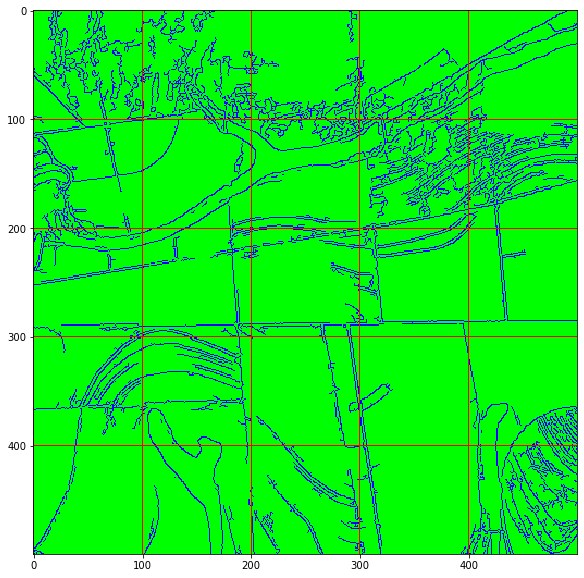

In [92]:
grid_size = 100

img_grid = np.copy(img_edges)
img_grid = np.bitwise_not(img_grid) 
height, width = img_grid.shape


for x in range(0, width -1, grid_size):    
    cv2.line(img_grid, (x, 0), (x, height), (125,0,0), 1)
        
for y in range(0, width -1, grid_size):
    cv2.line(img_grid, (0, y), (width, y), (125,0,0), 1)
        
        
plt.imshow(img_grid, cmap="brg")
plt.show()

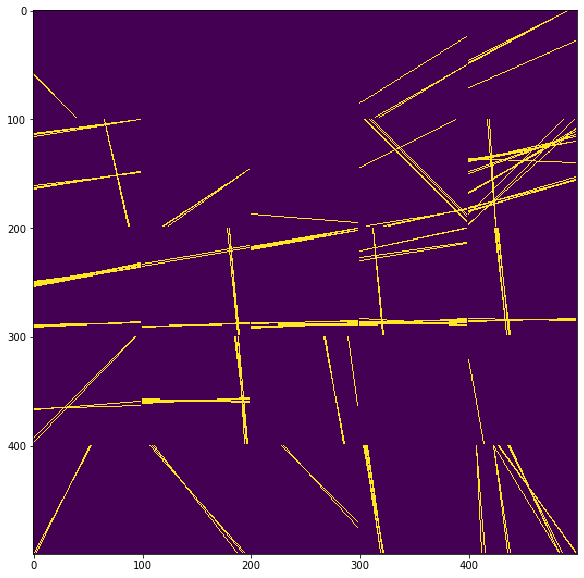

In [111]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 50  # minimum number of votes (intersections in Hough grid cell)

grid_size = 100
max_rho =  math.sqrt(2 * grid_size **2)
img_grid = np.copy(img_edges) 
img_hough = np.copy(img_edges) * 0
height, width = img_grid.shape

for line in range(0, height-1, grid_size):    
    for column in range(0, width -1, grid_size):
        cell = img_grid[line:line+grid_size-1, column:column+grid_size-1]    
        cell_copy = np.copy(cell)       
        clean_cell = np.zeros((grid_size-1,grid_size-1))
        lines = cv2.HoughLines(cell, _rho, _theta, threshold)
        if not lines is None:
            for _line in lines:
                rho,theta = _line[0]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + max_rho*(-b))
                y1 = int(y0 + max_rho*(a))
                x2 = int(x0 - max_rho*(-b))
                y2 = int(y0 - max_rho*(a))
                cv2.line(clean_cell, (x1, y1), (x2, y2), (255,0,0), 1)
                
                
               
        # Draw the lines on the  image
        img_hough[line:line+grid_size-1, column:column+grid_size-1] = clean_cell

plt.imshow(img_hough)
plt.show()        

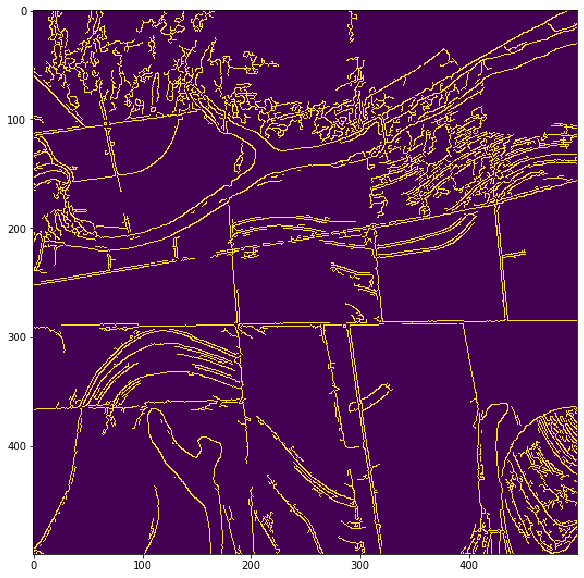

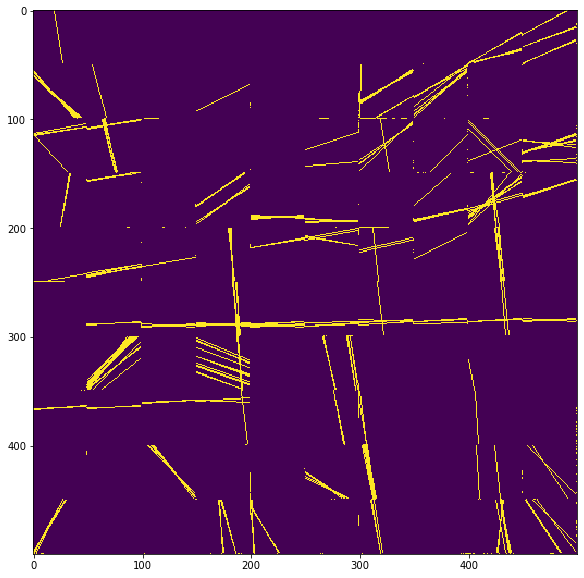

In [112]:
grid_size = 50

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 1000  # angular resolution in radians of the Hough grid
threshold = 30  # minimum number of votes (intersections in Hough grid cell)

max_rho =  math.sqrt(2 * grid_size **2)

img_grid = np.copy(img_edges)

height, width = img_grid.shape
new_image2 = np.copy(new_image)
for line in range(0, height-1, grid_size):    
    for column in range(0, width -1, grid_size):
        cell = img_grid[line:line+grid_size-1, column:column+grid_size-1]    
        cell_copy = np.copy(cell)       
        clean_cell = np.zeros((grid_size-1,grid_size-1))
        lines = cv2.HoughLines(cell, _rho, _theta, threshold)
        if not lines is None:
            for y in lines:
                rho,theta = y[0]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + max_rho*(-b))
                y1 = int(y0 + max_rho*(a))
                x2 = int(x0 - max_rho*(-b))
                y2 = int(y0 - max_rho*(a))
                cv2.line(clean_cell, (x1, y1), (x2, y2), (255,0,0), 1)
                
                
        # Draw the lines on the  image
        img_cp = cv2.addWeighted(cell_copy, 0.8, cell, 1, 0)
        new_image2[line:line+grid_size-1, column:column+grid_size-1] = clean_cell
                                       

plt.imshow(edges)
plt.show()
        
        
plt.imshow(new_image2)
plt.show()    

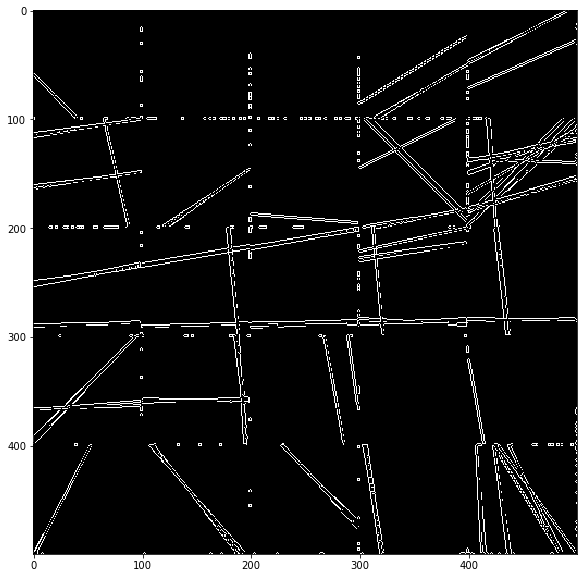

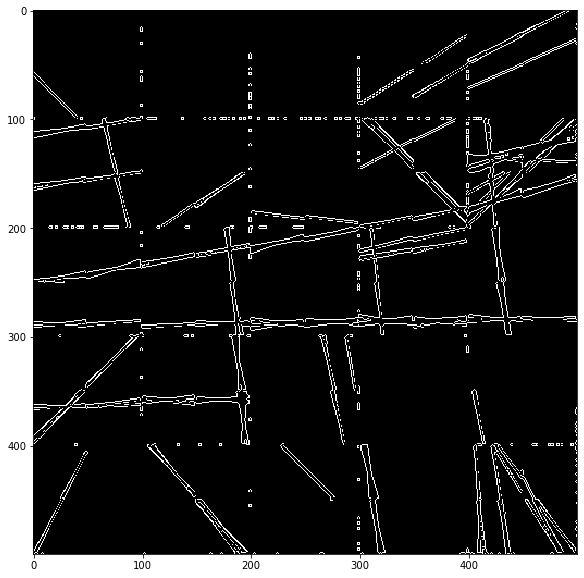

In [9]:
edges2 = cv2.Canny(new_image,10,50, None)
plt.imshow(edges2,cmap = 'gray')
plt.show()


edges3 = cv2.Canny(new_image2,10,50, None)
plt.imshow(edges3,cmap = 'gray')
plt.show()

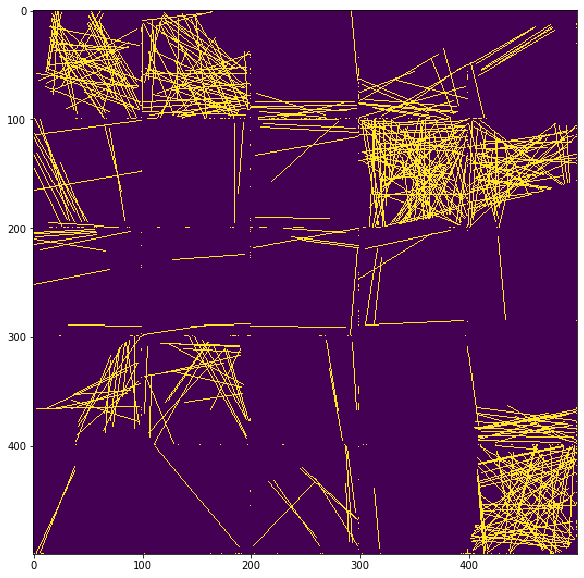

In [32]:

_rho = 10  # distance resolution in pixels of the Hough grid
_theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 20  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 25
grid_size = 100
max_rho =  math.sqrt(2 * grid_size **2)
img_grid = np.copy(edges)

height, width = img_grid.shape
new_image3 = np.copy(new_image)

for line in range(0, height-1, grid_size):       
    for column in range(0, width -1, grid_size):
        cell = img_grid[line:line+grid_size-1, column:column+grid_size-1]    
        cell_copy = np.copy(cell)       
        clean_cell = np.zeros((grid_size-1,grid_size-1))
        lines = cv2.HoughLinesP(cell, _rho, _theta, threshold, np.array([]), min_line_length, max_line_gap)
        if not lines is None:
            for _line in lines:
                for x1,y1,x2,y2 in _line:
                    cv2.line(clean_cell,(x1,y1),(x2,y2),(255,0,0),1)


        # Draw the lines on the  image
        new_image3[line:line+grid_size-1, column:column+grid_size-1] = clean_cell

     
plt.imshow(new_image3)
plt.show()  
